In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

2023-07-26 06:17:44.623595: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 06:17:44.685779: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-26 06:17:44.690072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-26 06:17:45.909002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
import losses
USE_CPU = True

if USE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
NUM_LANES = 2
INPUT_SIZE = (288, 800)
# CLS_SHAPE = (100, 20, NUM_LANES)
CLS_SHAPE = (20, 100, NUM_LANES)

INPUT_SHAPE = (*INPUT_SIZE, 3)
OUTPUT_SHAPE = CLS_SHAPE

PREFETCH_SIZE = 200

DTYPE = tf.float32

TAKE_LLAMAS_MAX = 1000
TAKE_CULANE_MAX = 0
TAKE_MIWULA_MAX = 0 # all of them

# Ratio of validation data vs training data
VALID_RATIO = 0.3

BATCH_SIZE = 8 # tune to available GPU memory
PREFETCH_SIZE = 200 # tune to available memory


EPOCHS = 20 # training epochs


In [4]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

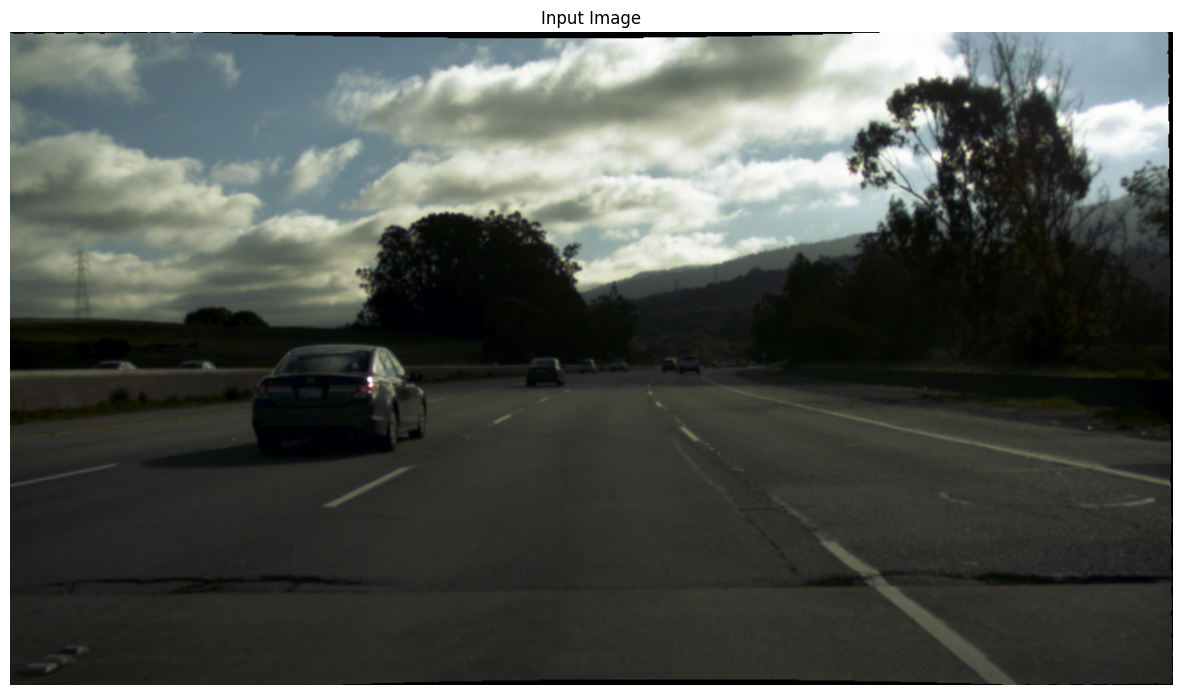

In [5]:
test = cv2.imread('../../data/color_images/test/images-2014-12-22-13-22-35_mapping_280S_2nd_lane/1419283775_0857456000_color_rect.png')
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)


display([test])


1/1 [==============================] - 1s 961ms/step


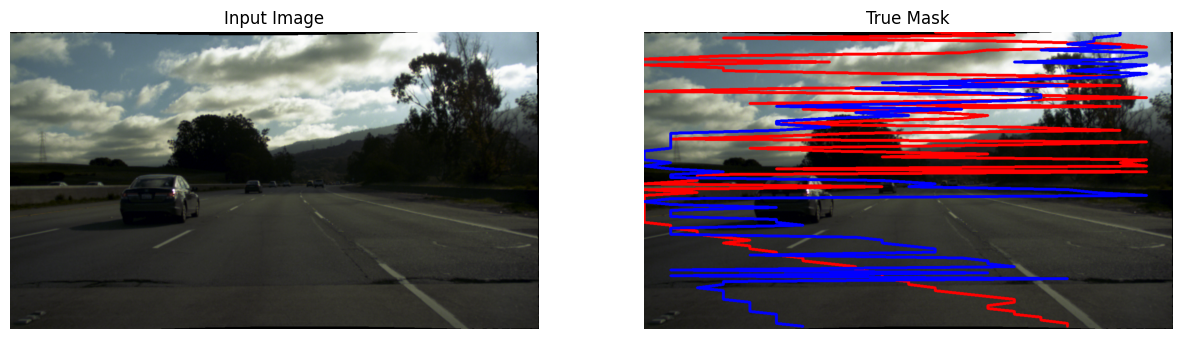

In [6]:
def resize_img(img, shape):
    w = img.shape[1]
    h = img.shape[0]
    
    ratio = shape[1] / shape[0]
    
    tgt = img[h-int(w/ratio):h,0:w]
    tgt = cv2.resize(tgt, (shape[1], shape[0]))
    return tgt

def pred_to_polylines(pred, imgshape):
    n = tf.math.argmax(pred)
    
    n = np.round((n / CLS_SHAPE[0]) * imgshape[1]).astype(np.int32)
    y = np.arange(0, len(n)).reshape(-1,1)
    y = np.round((y / CLS_SHAPE[1]) * imgshape[0]).astype(np.int32)
        
    for i in range(CLS_SHAPE[-1]):
        x = np.array(n[:,i]).reshape(-1,1)
        
        yield(np.int32([np.hstack((x,y))]))

def pipeline(img_orig):
    img = resize_img(img_orig, INPUT_SIZE) / 255
    
    img_inp = tf.expand_dims(img, axis=0)

    ufm = tf.keras.models.load_model('ultrafast.tf', custom_objects={'loss': losses.ultrafast_loss}, compile=False)
    ufm.compile(optimizer='adam', loss=losses.ultrafast_loss)
    pred = ufm.predict(img_inp)[0]
    pred_img = tf.zeros((CLS_SHAPE[0], CLS_SHAPE[1], 3-CLS_SHAPE[2]))
    pred_img = tf.concat([pred, pred_img], -1)
    
    pred_img = np.flipud(np.rot90(pred_img))
    
    img2 = img_orig.copy()
    
    i = 0
    for poly in pred_to_polylines(pred, img2.shape):
        color = (255,0)
        if i > 0:
            color = (0,0,255)
        cv2.polylines(img2, poly, False, color, thickness=5)
        i = i + 1
    
    return img2#, pred_img

p = pipeline(test)
#pred = p[0]

display([test, p])

In [7]:
# from losses import ultrafast_loss

# ufm = tf.keras.models.load_model('uf-llamas-16k-20e.tf', custom_objects={'focal_loss_fixed': ultrafast_loss}, compile=False)
# ufm.compile(optimizer='adam', loss=ultrafast_loss)

In [9]:
from moviepy.editor import VideoFileClip

clip = 'test_video.mp4'

clip1 = VideoFileClip(clip)
driving_clip = clip1.fl_image(pipeline)
driving_clip.write_videofile('out2_ultrafast.mp4', audio=False)

1/1 [==============================] - 1s 546ms/step
Moviepy - Building video out2_ultrafast.mp4.
Moviepy - Writing video out2_ultrafast.mp4



t:   0%|                | 0/38 [00:00<?, ?it/s, now=None]

1/1 [==============================] - 1s 785ms/step


t:   5%|▍       | 2/38 [00:04<01:27,  2.43s/it, now=None]

1/1 [==============================] - 1s 536ms/step


t:   8%|▋       | 3/38 [00:09<01:55,  3.31s/it, now=None]

1/1 [==============================] - 1s 516ms/step


t:  11%|▊       | 4/38 [00:13<02:05,  3.70s/it, now=None]

1/1 [==============================] - 0s 499ms/step


t:  13%|█       | 5/38 [00:18<02:09,  3.94s/it, now=None]

1/1 [==============================] - 1s 518ms/step


t:  16%|█▎      | 6/38 [00:22<02:12,  4.16s/it, now=None]

1/1 [==============================] - 1s 512ms/step


t:  18%|█▍      | 7/38 [00:27<02:10,  4.22s/it, now=None]

1/1 [==============================] - 1s 510ms/step


t:  21%|█▋      | 8/38 [00:31<02:07,  4.24s/it, now=None]

1/1 [==============================] - 1s 510ms/step


t:  24%|█▉      | 9/38 [00:35<02:06,  4.36s/it, now=None]

1/1 [==============================] - 1s 540ms/step


t:  26%|█▊     | 10/38 [00:40<02:02,  4.39s/it, now=None]

1/1 [==============================] - 1s 557ms/step


t:  29%|██     | 11/38 [00:45<02:01,  4.49s/it, now=None]

1/1 [==============================] - 1s 520ms/step


t:  32%|██▏    | 12/38 [00:49<01:58,  4.56s/it, now=None]

1/1 [==============================] - 1s 514ms/step


t:  34%|██▍    | 13/38 [00:54<01:55,  4.61s/it, now=None]

1/1 [==============================] - 1s 532ms/step


t:  37%|██▌    | 14/38 [00:59<01:49,  4.56s/it, now=None]

1/1 [==============================] - 1s 514ms/step


t:  39%|██▊    | 15/38 [01:03<01:45,  4.59s/it, now=None]

1/1 [==============================] - 1s 508ms/step


t:  42%|██▉    | 16/38 [01:08<01:40,  4.58s/it, now=None]

1/1 [==============================] - 1s 506ms/step


t:  45%|███▏   | 17/38 [01:12<01:35,  4.57s/it, now=None]

1/1 [==============================] - 1s 543ms/step


t:  47%|███▎   | 18/38 [01:17<01:31,  4.56s/it, now=None]

1/1 [==============================] - 1s 520ms/step


t:  50%|███▌   | 19/38 [01:21<01:25,  4.52s/it, now=None]

1/1 [==============================] - 0s 499ms/step


t:  53%|███▋   | 20/38 [01:26<01:21,  4.51s/it, now=None]

1/1 [==============================] - 1s 512ms/step


t:  55%|███▊   | 21/38 [01:31<01:18,  4.63s/it, now=None]

1/1 [==============================] - 1s 530ms/step


t:  58%|████   | 22/38 [01:35<01:13,  4.58s/it, now=None]

1/1 [==============================] - 1s 518ms/step


t:  61%|████▏  | 23/38 [01:40<01:08,  4.55s/it, now=None]

1/1 [==============================] - 1s 521ms/step


t:  63%|████▍  | 24/38 [01:44<01:03,  4.57s/it, now=None]

1/1 [==============================] - 1s 522ms/step


t:  66%|████▌  | 25/38 [01:49<00:58,  4.52s/it, now=None]

1/1 [==============================] - 1s 515ms/step


t:  68%|████▊  | 26/38 [01:53<00:53,  4.48s/it, now=None]

1/1 [==============================] - 1s 510ms/step


t:  71%|████▉  | 27/38 [01:58<00:49,  4.53s/it, now=None]

1/1 [==============================] - 1s 537ms/step


t:  74%|█████▏ | 28/38 [02:02<00:45,  4.52s/it, now=None]

1/1 [==============================] - 1s 563ms/step


t:  76%|█████▎ | 29/38 [02:07<00:41,  4.56s/it, now=None]

1/1 [==============================] - 1s 563ms/step


t:  79%|█████▌ | 30/38 [02:11<00:36,  4.59s/it, now=None]

1/1 [==============================] - 1s 508ms/step


t:  82%|█████▋ | 31/38 [02:16<00:31,  4.54s/it, now=None]

1/1 [==============================] - 1s 512ms/step


t:  84%|█████▉ | 32/38 [02:20<00:26,  4.48s/it, now=None]

1/1 [==============================] - 1s 505ms/step


t:  87%|██████ | 33/38 [02:25<00:22,  4.52s/it, now=None]

1/1 [==============================] - 1s 522ms/step


t:  89%|██████▎| 34/38 [02:29<00:17,  4.49s/it, now=None]

1/1 [==============================] - 1s 528ms/step


t:  92%|██████▍| 35/38 [02:34<00:13,  4.54s/it, now=None]

1/1 [==============================] - 1s 567ms/step


t:  95%|██████▋| 36/38 [02:39<00:09,  4.56s/it, now=None]

1/1 [==============================] - 1s 511ms/step


t:  97%|██████▊| 37/38 [02:43<00:04,  4.54s/it, now=None]

1/1 [==============================] - 1s 511ms/step


t: 100%|███████| 38/38 [02:48<00:00,  4.57s/it, now=None]

1/1 [==============================] - 1s 554ms/step


Moviepy - Done !
Moviepy - video ready out2_ultrafast.mp4


t:  14%|█▎        | 1340/9778 [10:15<1:07:26,  2.09it/s, now=None]

t:  14%|█▎        | 1341/9778 [10:15<1:08:13,  2.06it/s, now=None]

t:  14%|█▎        | 1342/9778 [10:16<1:08:39,  2.05it/s, now=None]

t:  14%|█▎        | 1343/9778 [10:16<1:09:07,  2.03it/s, now=None]

t:  14%|█▎        | 1344/9778 [10:17<1:09:24,  2.02it/s, now=None]

t:  14%|█▍        | 1345/9778 [10:17<1:05:38,  2.14it/s, now=None]

t:  14%|█▍        | 1346/9778 [10:18<1:06:54,  2.10it/s, now=None]

t:  14%|█▍        | 1347/9778 [10:18<1:07:08,  2.09it/s, now=None]

t:  14%|█▍        | 1348/9778 [10:18<1:00:27,  2.32it/s, now=None]

t:  14%|█▍        | 1349/9778 [10:19<58:22,  2.41it/s, now=None]  

t:  14%|█▍        | 1350/9778 [10:19<58:18,  2.41it/s, now=None]

t:  14%|█▍        | 1351/9778 [10:20<1:01:43,  2.28it/s, now=None]

t:  14%|█▍        | 1352/9778 [10:20<1:04:03,  2.19it/s, now=None]

t:  14%|█▍        | 1353/9778 [10:21<1:02:17,  2.25it/s, now=None]

t:  14%|█▍        | 1354/9778 [10:21<1:04:32,  2.1

t:  15%|█▍        | 1450/9778 [11:06<1:01:18,  2.26it/s, now=None]

t:  15%|█▍        | 1451/9778 [11:06<59:41,  2.33it/s, now=None]  

t:  15%|█▍        | 1452/9778 [11:07<1:02:30,  2.22it/s, now=None]

t:  15%|█▍        | 1453/9778 [11:07<1:03:56,  2.17it/s, now=None]

t:  15%|█▍        | 1454/9778 [11:07<1:02:09,  2.23it/s, now=None]

t:  15%|█▍        | 1455/9778 [11:08<1:03:44,  2.18it/s, now=None]

t:  15%|█▍        | 1456/9778 [11:08<1:05:16,  2.12it/s, now=None]

t:  15%|█▍        | 1457/9778 [11:09<1:02:45,  2.21it/s, now=None]

t:  15%|█▍        | 1458/9778 [11:09<1:00:40,  2.29it/s, now=None]

t:  15%|█▍        | 1459/9778 [11:10<1:03:21,  2.19it/s, now=None]

t:  15%|█▍        | 1460/9778 [11:10<1:05:00,  2.13it/s, now=None]

t:  15%|█▍        | 1461/9778 [11:11<1:02:26,  2.22it/s, now=None]

t:  15%|█▍        | 1462/9778 [11:11<1:04:10,  2.16it/s, now=None]

t:  15%|█▍        | 1463/9778 [11:12<1:05:07,  2.13it/s, now=None]

t:  15%|█▍        | 1464/9778 [11:12<1:02:56,  2

t:  16%|█▌        | 1560/9778 [11:55<59:38,  2.30it/s, now=None]  

t:  16%|█▌        | 1561/9778 [11:55<1:02:22,  2.20it/s, now=None]

t:  16%|█▌        | 1562/9778 [11:56<1:03:38,  2.15it/s, now=None]

t:  16%|█▌        | 1563/9778 [11:56<1:01:30,  2.23it/s, now=None]

t:  16%|█▌        | 1564/9778 [11:57<1:03:19,  2.16it/s, now=None]

t:  16%|█▌        | 1565/9778 [11:57<1:00:51,  2.25it/s, now=None]

t:  16%|█▌        | 1566/9778 [11:58<1:02:50,  2.18it/s, now=None]

t:  16%|█▌        | 1567/9778 [11:58<1:04:14,  2.13it/s, now=None]

t:  16%|█▌        | 1568/9778 [11:59<1:02:12,  2.20it/s, now=None]

t:  16%|█▌        | 1569/9778 [11:59<1:00:12,  2.27it/s, now=None]

t:  16%|█▌        | 1570/9778 [11:59<1:02:04,  2.20it/s, now=None]

t:  16%|█▌        | 1571/9778 [12:00<1:04:26,  2.12it/s, now=None]

t:  16%|█▌        | 1572/9778 [12:00<1:05:03,  2.10it/s, now=None]

t:  16%|█▌        | 1573/9778 [12:01<1:01:57,  2.21it/s, now=None]

t:  16%|█▌        | 1574/9778 [12:01<1:03:27,  2

t:  17%|█▋        | 1670/9778 [12:45<1:06:29,  2.03it/s, now=None]

t:  17%|█▋        | 1671/9778 [12:46<1:03:12,  2.14it/s, now=None]

t:  17%|█▋        | 1672/9778 [12:46<1:03:57,  2.11it/s, now=None]

t:  17%|█▋        | 1673/9778 [12:47<1:01:19,  2.20it/s, now=None]

t:  17%|█▋        | 1674/9778 [12:47<1:03:28,  2.13it/s, now=None]

t:  17%|█▋        | 1675/9778 [12:48<1:04:44,  2.09it/s, now=None]

t:  17%|█▋        | 1676/9778 [12:48<1:04:55,  2.08it/s, now=None]

t:  17%|█▋        | 1677/9778 [12:48<1:02:13,  2.17it/s, now=None]

t:  17%|█▋        | 1678/9778 [12:49<1:07:14,  2.01it/s, now=None]

t:  17%|█▋        | 1679/9778 [12:49<1:03:48,  2.12it/s, now=None]

t:  17%|█▋        | 1680/9778 [12:50<1:04:56,  2.08it/s, now=None]

t:  17%|█▋        | 1681/9778 [12:50<1:05:00,  2.08it/s, now=None]

t:  17%|█▋        | 1682/9778 [12:51<1:02:14,  2.17it/s, now=None]

t:  17%|█▋        | 1683/9778 [12:51<1:03:41,  2.12it/s, now=None]

t:  17%|█▋        | 1684/9778 [12:52<1:00:58,  2

t:  18%|█▊        | 1780/9778 [13:37<59:48,  2.23it/s, now=None]  

t:  18%|█▊        | 1781/9778 [13:37<58:05,  2.29it/s, now=None]

t:  18%|█▊        | 1782/9778 [13:38<1:00:16,  2.21it/s, now=None]

t:  18%|█▊        | 1783/9778 [13:38<58:35,  2.27it/s, now=None]  

t:  18%|█▊        | 1784/9778 [13:39<1:00:55,  2.19it/s, now=None]

t:  18%|█▊        | 1785/9778 [13:39<1:02:05,  2.15it/s, now=None]

t:  18%|█▊        | 1786/9778 [13:40<1:03:21,  2.10it/s, now=None]

t:  18%|█▊        | 1787/9778 [13:40<56:54,  2.34it/s, now=None]  

t:  18%|█▊        | 1788/9778 [13:40<55:37,  2.39it/s, now=None]

t:  18%|█▊        | 1789/9778 [13:41<55:07,  2.42it/s, now=None]

t:  18%|█▊        | 1790/9778 [13:41<58:32,  2.27it/s, now=None]

t:  18%|█▊        | 1791/9778 [13:42<56:56,  2.34it/s, now=None]

t:  18%|█▊        | 1792/9778 [13:42<59:20,  2.24it/s, now=None]

t:  18%|█▊        | 1793/9778 [13:43<1:01:24,  2.17it/s, now=None]

t:  18%|█▊        | 1794/9778 [13:43<59:33,  2.23it/s, now=N

t:  19%|█▉        | 1891/9778 [14:29<1:00:35,  2.17it/s, now=None]

t:  19%|█▉        | 1892/9778 [14:29<1:01:51,  2.12it/s, now=None]

t:  19%|█▉        | 1893/9778 [14:30<59:27,  2.21it/s, now=None]  

t:  19%|█▉        | 1894/9778 [14:30<1:00:53,  2.16it/s, now=None]

t:  19%|█▉        | 1895/9778 [14:31<58:41,  2.24it/s, now=None]  

t:  19%|█▉        | 1896/9778 [14:31<1:00:39,  2.17it/s, now=None]

t:  19%|█▉        | 1897/9778 [14:32<1:01:40,  2.13it/s, now=None]

t:  19%|█▉        | 1898/9778 [14:32<59:29,  2.21it/s, now=None]  

t:  19%|█▉        | 1899/9778 [14:33<1:01:15,  2.14it/s, now=None]

t:  19%|█▉        | 1900/9778 [14:33<1:06:18,  1.98it/s, now=None]

t:  19%|█▉        | 1901/9778 [14:34<1:05:42,  2.00it/s, now=None]

t:  19%|█▉        | 1902/9778 [14:34<1:02:22,  2.10it/s, now=None]

t:  19%|█▉        | 1903/9778 [14:35<1:03:17,  2.07it/s, now=None]

t:  19%|█▉        | 1904/9778 [14:35<1:03:43,  2.06it/s, now=None]

t:  19%|█▉        | 1905/9778 [14:35<1:00:27,  2

t:  20%|██        | 2002/9778 [15:21<1:04:20,  2.01it/s, now=None]

t:  20%|██        | 2003/9778 [15:21<1:00:59,  2.12it/s, now=None]

t:  20%|██        | 2004/9778 [15:22<1:01:49,  2.10it/s, now=None]

t:  21%|██        | 2005/9778 [15:22<58:58,  2.20it/s, now=None]  

t:  21%|██        | 2006/9778 [15:22<1:00:50,  2.13it/s, now=None]

t:  21%|██        | 2007/9778 [15:23<1:01:18,  2.11it/s, now=None]

t:  21%|██        | 2008/9778 [15:23<58:56,  2.20it/s, now=None]  

t:  21%|██        | 2009/9778 [15:24<1:00:13,  2.15it/s, now=None]

t:  21%|██        | 2010/9778 [15:24<1:01:36,  2.10it/s, now=None]

t:  21%|██        | 2011/9778 [15:25<59:09,  2.19it/s, now=None]  

t:  21%|██        | 2012/9778 [15:25<1:00:33,  2.14it/s, now=None]

t:  21%|██        | 2013/9778 [15:26<1:01:28,  2.11it/s, now=None]

t:  21%|██        | 2014/9778 [15:26<1:02:18,  2.08it/s, now=None]

t:  21%|██        | 2015/9778 [15:27<59:49,  2.16it/s, now=None]  

t:  21%|██        | 2016/9778 [15:27<1:01:05,  2

t:  22%|██▏       | 2113/9778 [16:12<57:48,  2.21it/s, now=None]

t:  22%|██▏       | 2114/9778 [16:12<56:15,  2.27it/s, now=None]

t:  22%|██▏       | 2115/9778 [16:13<54:46,  2.33it/s, now=None]

t:  22%|██▏       | 2116/9778 [16:13<57:11,  2.23it/s, now=None]

t:  22%|██▏       | 2117/9778 [16:14<55:49,  2.29it/s, now=None]

t:  22%|██▏       | 2118/9778 [16:14<57:53,  2.21it/s, now=None]

t:  22%|██▏       | 2119/9778 [16:15<59:40,  2.14it/s, now=None]

t:  22%|██▏       | 2120/9778 [16:15<1:00:41,  2.10it/s, now=None]

t:  22%|██▏       | 2121/9778 [16:15<58:28,  2.18it/s, now=None]  

t:  22%|██▏       | 2122/9778 [16:16<1:03:21,  2.01it/s, now=None]

t:  22%|██▏       | 2123/9778 [16:17<1:03:04,  2.02it/s, now=None]

t:  22%|██▏       | 2124/9778 [16:17<59:50,  2.13it/s, now=None]  

t:  22%|██▏       | 2125/9778 [16:17<57:26,  2.22it/s, now=None]

t:  22%|██▏       | 2126/9778 [16:18<59:09,  2.16it/s, now=None]

t:  22%|██▏       | 2127/9778 [16:18<56:44,  2.25it/s, now=None]



t:  23%|██▎       | 2225/9778 [17:03<52:36,  2.39it/s, now=None]

t:  23%|██▎       | 2226/9778 [17:04<55:02,  2.29it/s, now=None]

t:  23%|██▎       | 2227/9778 [17:04<53:54,  2.33it/s, now=None]

t:  23%|██▎       | 2228/9778 [17:04<52:57,  2.38it/s, now=None]

t:  23%|██▎       | 2229/9778 [17:05<55:36,  2.26it/s, now=None]

t:  23%|██▎       | 2230/9778 [17:05<58:01,  2.17it/s, now=None]

t:  23%|██▎       | 2231/9778 [17:06<55:36,  2.26it/s, now=None]

t:  23%|██▎       | 2232/9778 [17:06<57:34,  2.18it/s, now=None]

t:  23%|██▎       | 2233/9778 [17:07<55:29,  2.27it/s, now=None]

t:  23%|██▎       | 2234/9778 [17:07<57:57,  2.17it/s, now=None]

t:  23%|██▎       | 2235/9778 [17:08<59:07,  2.13it/s, now=None]

t:  23%|██▎       | 2236/9778 [17:08<56:37,  2.22it/s, now=None]

t:  23%|██▎       | 2237/9778 [17:09<54:46,  2.29it/s, now=None]

t:  23%|██▎       | 2238/9778 [17:09<57:00,  2.20it/s, now=None]

t:  23%|██▎       | 2239/9778 [17:10<58:16,  2.16it/s, now=None]

t:  23%|██

t:  24%|██▍       | 2338/9778 [17:55<56:26,  2.20it/s, now=None]

t:  24%|██▍       | 2339/9778 [17:56<54:54,  2.26it/s, now=None]

t:  24%|██▍       | 2340/9778 [17:56<56:25,  2.20it/s, now=None]

t:  24%|██▍       | 2341/9778 [17:57<54:53,  2.26it/s, now=None]

t:  24%|██▍       | 2342/9778 [17:57<53:28,  2.32it/s, now=None]

t:  24%|██▍       | 2343/9778 [17:57<55:53,  2.22it/s, now=None]

t:  24%|██▍       | 2344/9778 [17:58<54:22,  2.28it/s, now=None]

t:  24%|██▍       | 2345/9778 [17:58<56:03,  2.21it/s, now=None]

t:  24%|██▍       | 2346/9778 [17:59<54:22,  2.28it/s, now=None]

t:  24%|██▍       | 2347/9778 [17:59<56:24,  2.20it/s, now=None]

t:  24%|██▍       | 2348/9778 [18:00<54:34,  2.27it/s, now=None]

t:  24%|██▍       | 2349/9778 [18:00<56:31,  2.19it/s, now=None]

t:  24%|██▍       | 2350/9778 [18:01<57:43,  2.14it/s, now=None]

t:  24%|██▍       | 2351/9778 [18:01<55:54,  2.21it/s, now=None]

t:  24%|██▍       | 2352/9778 [18:02<57:08,  2.17it/s, now=None]

t:  24%|██

t:  25%|██▌       | 2451/9778 [18:47<56:05,  2.18it/s, now=None]

t:  25%|██▌       | 2452/9778 [18:48<57:26,  2.13it/s, now=None]

t:  25%|██▌       | 2453/9778 [18:48<58:26,  2.09it/s, now=None]

t:  25%|██▌       | 2454/9778 [18:49<55:45,  2.19it/s, now=None]

t:  25%|██▌       | 2455/9778 [18:49<57:19,  2.13it/s, now=None]

t:  25%|██▌       | 2456/9778 [18:50<58:03,  2.10it/s, now=None]

t:  25%|██▌       | 2457/9778 [18:50<55:32,  2.20it/s, now=None]

t:  25%|██▌       | 2458/9778 [18:50<57:04,  2.14it/s, now=None]

t:  25%|██▌       | 2459/9778 [18:51<57:56,  2.11it/s, now=None]

t:  25%|██▌       | 2460/9778 [18:51<55:35,  2.19it/s, now=None]

t:  25%|██▌       | 2461/9778 [18:52<53:29,  2.28it/s, now=None]

t:  25%|██▌       | 2462/9778 [18:52<52:12,  2.34it/s, now=None]

t:  25%|██▌       | 2463/9778 [18:53<54:20,  2.24it/s, now=None]

t:  25%|██▌       | 2464/9778 [18:53<53:04,  2.30it/s, now=None]

t:  25%|██▌       | 2465/9778 [18:53<51:55,  2.35it/s, now=None]

t:  25%|██

KeyboardInterrupt: 